## Simple LPC vocoder
Demonstrates extracting LPC coefficients and resynthesis to apply vocoding effects.
Also includes functions for conversion to/from line spectral pair format.

## MIT License

    Copyright (c) 2017 John Williamson
    Copyright (c) 2008 Cournapeau David

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in
    all copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
    THE SOFTWARE.

In [ ]:
import numpy as np
import scipy, scipy.io, scipy.io.wavfile, scipy.signal
import IPython


In [ ]:
# This function is copied directly from https://github.com/cournape/talkbox/blob/master/scikits/talkbox/linpred/py_lpc.py
# Copyright (c) 2008 Cournapeau David
# (MIT licensed)
def levinson_1d(r, order):
    """Levinson-Durbin recursion, to efficiently solve symmetric linear systems
    with toeplitz structure.

    Parameters
    ---------
    r : array-like
        input array to invert (since the matrix is symmetric Toeplitz, the
        corresponding pxp matrix is defined by p items only). Generally the
        autocorrelation of the signal for linear prediction coefficients
        estimation. The first item must be a non zero real.

    Notes
    ----
    This implementation is in python, hence unsuitable for any serious
    computation. Use it as educational and reference purpose only.

    Levinson is a well-known algorithm to solve the Hermitian toeplitz
    equation:

                       _          _
        -R[1] = R[0]   R[1]   ... R[p-1]    a[1]
         :      :      :          :      *  :
         :      :      :          _      *  :
        -R[p] = R[p-1] R[p-2] ... R[0]      a[p]
                       _
    with respect to a (  is the complex conjugate). Using the special symmetry
    in the matrix, the inversion can be done in O(p^2) instead of O(p^3).
    """
    r = np.atleast_1d(r)
    if r.ndim > 1:
        raise ValueError("Only rank 1 are supported for now.")

    n = r.size
    if n < 1:
        raise ValueError("Cannot operate on empty array !")
    elif order > n - 1:
        raise ValueError("Order should be <= size-1")

    if not np.isreal(r[0]):
        raise ValueError("First item of input must be real.")
    elif not np.isfinite(1/r[0]):
        raise ValueError("First item should be != 0")

    # Estimated coefficients
    a = np.empty(order+1, r.dtype)
    # temporary array
    t = np.empty(order+1, r.dtype)
    # Reflection coefficients
    k = np.empty(order, r.dtype)

    a[0] = 1.
    e = r[0]

    for i in xrange(1, order+1):
        acc = r[i]
        for j in range(1, i):
            acc += a[j] * r[i-j]
        k[i-1] = -acc / e
        a[i] = k[i-1]

        for j in range(order):
            t[j] = a[j]

        for j in range(1, i):
            a[j] += k[i-1] * np.conj(t[i-j])

        e *= 1 - k[i-1] * np.conj(k[i-1])

    return a, e, k

----

In [ ]:
def play_sound(sound):
    """Play a mono 44Khz sound file in the browser"""
    return IPython.display.display(IPython.display.Audio(sound,rate=44100))

In [772]:
from numpy.polynomial import polynomial as P

def lsp_to_lpc(lsp):  
    """Convert line spectral pairs to LPC"""
    ps = np.concatenate((lsp[:,0], -lsp[::-1,0], [np.pi]))
    qs = np.concatenate((lsp[:,1], [0], -lsp[::-1,1]))
    
    p = np.cos(ps) - np.sin(ps)*1.0j
    q = np.cos(qs) - np.sin(qs)*1.0j
    
    p = np.real(P.polyfromroots(p))
    q = -np.real(P.polyfromroots(q))
    
    a = 0.5 * (p+q)
    return a[:-1]

    
def lpc_noise_synthesize(lpc, samples=10000):
    """Apply LPC coefficients to white noise"""
    phase = np.random.uniform(0,0.5,(samples))
    signal= scipy.signal.lfilter([1.], lpc, phase)        
    return signal
    
def lpc_buzz_synthesize(lpc, f, sr, samples=10000):       
    """Apply LPC coefficients to a sawtooth with the given frequency and sample rate"""
    phase = scipy.signal.sawtooth(2*np.pi*f*np.arange(samples)/(sr))
    signal= scipy.signal.lfilter([1.], lpc, phase)        
    return signal

def lpc_to_lsp(lpc):    
    """Convert LPC to line spectral pairs"""
    l = len(lpc)+1
    a = np.zeros((l,))        
    a[0:-1] = lpc
    p = np.zeros((l,))
    q = np.zeros((l,))    
    for i in range(l):
        j = l-i-1
        p[i] = a[i] + a[j]
        q[i] = a[i] - a[j]
    
    ps = np.sort(numpy.angle(np.roots(p)))
    qs = np.sort(numpy.angle(np.roots(q)))            
    lsp = np.vstack([ps[:len(ps)//2],qs[:len(qs)//2]]).T    
    return lsp

def lpc_to_formants(lpc, sr):    
    """Convert LPC to formants    
    """
        
    # extract roots, get angle and radius
    roots = np.roots(lpc)
    
    pos_roots = roots[np.imag(roots)>=0]
    if len(pos_roots)<len(roots)//2:
        pos_roots = list(pos_roots) + [0] * (len(roots)//2 - len(pos_roots))
    if len(pos_roots)>len(roots)//2:
        pos_roots = pos_roots[:len(roots)//2]
    
    w = np.angle(pos_roots)
    a = np.abs(pos_roots)
    
    order = np.argsort(w)
    w = w[order]
    a = a[order]
    
    freqs = w * (sr/(2*np.pi))
    bws =  -0.5 * (sr/(2*np.pi)) * np.log(a)    
    
    # exclude DC and sr/2 frequencies
    return freqs, bws
    
    


In [739]:
def load_wave(fname):
    """Load a 16 bit wave file and return normalised in 0,1 range"""
    # load and return a wave file
    sr, wave = scipy.io.wavfile.read(fname)
    return wave/32768.0

In [740]:
def lpc(wave, order):
    """Compute LPC of the waveform. 
    a: the LPC coefficients
    e: the total error
    k: the reflection coefficients
    
    Typically only a is required.
    """    
    # only use right half of autocorrelation, normalised by total length
    autocorr = scipy.signal.correlate(wave, wave)[len(wave)-1:]/len(wave)
    a, e, k  = levinson_1d(autocorr, order)
    return a,e,k
        

## Testing the vocoder
We can compute the LPC coefficients for a single window (from a vowel sound) and then try resynthesizing by applying
the LPC filter to a sawtooth wave and to white noise.

In [ ]:
# load two test sounds
a_vowel = load_wave("wavs/aww.wav")
o_vowel = load_wave("wavs/oh.wav")


### Play the original sounds

In [ ]:
# play the sounds
play_sound(a_vowel)
play_sound(o_vowel)

### Compute LPC

In [ ]:
# only a is important here in the a,e,k return values
# a is the reconstruction coefficients
o_lpc,e,k = lpc(o_vowel, 20)
a_lpc,e,k = lpc(a_vowel, 20)

In [745]:
print(lpc_to_formants(o_lpc, sr=44100))

(array([     0.        ,    490.39245901,   3629.52164062,   6966.99412422,
         9308.46669358,  11601.43400914,  15192.37206018,  18137.54571415]), array([ 627.79844659,   72.36918629,  474.31260993,  110.30396792,
        361.14644793,  527.66934379,  627.32913848,  619.30423092]))


In [ ]:
# verify that LPC->LSP->LPC reconstructs correctly
print(np.allclose(lsp_to_lpc(lpc_to_lsp(o_lpc)), o_lpc))
print(np.allclose(lsp_to_lpc(lpc_to_lsp(a_lpc)), a_lpc))

### Resynthesize
* "a": white noise synthesis
* "o": 100 Hz sawtooth synthesis

In [ ]:
# now generate a sawtooth wave, and filter using these coefficients
o_lpc_wave = lpc_buzz_synthesize(o_lpc, f=100, sr=44100, samples=10000)
a_lpc_wave = lpc_noise_synthesize(a_lpc, samples=10000)
# play the result
play_sound(a_lpc_wave)
play_sound(o_lpc_wave)

----
## General vocoder

In [ ]:
def modfm_buzz(samples, f, sr, k):
    """Generate a pulse train using modfm:
        y(t) = cos(x(t)) * exp(cos(x(t))*k - k)
        
        samples: number of samples to generate
        f: base frequency (Hz)
        sr: sample rate (Hz)
        k: modulation depth; higher has more harmonics but increases risk of aliasing
        (e.g. k=1000 for f=50, k=100 for f=200, k=2 for f=4000)        
    
    """
    t = np.arange(samples)
    phase = (f*2*np.pi * (t/float(sr)))
    # simple pulse oscillator (ModFM)
    buzz = np.cos(phase) * np.exp(np.cos(phase)*k-k)    
   
    return buzz

def noise(samples):
    """Generate white noise in range [-1,1]
    
    samples: number of samples to generate
    """
    return np.random.uniform(-1,1,size=samples)

In [949]:

def lpc_vocode(wave, frame_len, order, carrier, residual_amp=0.0, vocode_amp=1.0, env=False, 
               freq_shift=1.0):    
    """
    Apply LPC vocoding to a pair of signals using 50% overlap-add Hamming window resynthesis
    The modulator `wave` is applied to the carrier `imposed`
    
    Parameters:
    ---
    wave: modulator wave
    frame_len: length of frames
    order: LPC order (typically 2-30)
    carrier: carrier signal; should be at least as long as wave
    residual_amp: amplitude of LPC residual to include in output
    vocode_amp: amplitude of vocoded signal 
    env: if True, the original volume envelope of wave is imposed on the output
          otherwise, no volume modulation is applied
    freq_shift: (default 1.0) shift the frequency of the resonances by the given scale factor. Warning :
        values >1.1 are usually unstable, and values <0.5 likewise.
    """
    
    # precompute the hamming window
    window = scipy.signal.hann(frame_len)
    t = np.arange(frame_len)
    #allocate the array for the output
    vocode = np.zeros(len(wave+frame_len))    
    last = np.zeros(order)
    # 50% window steps for overlap-add
    for i in range(0,len(wave),frame_len//2):
        # slice the wave
        wave_slice = wave[i:i+frame_len]
        carrier_slice = carrier[i:i+frame_len]
        if len(wave_slice)==frame_len:                        
            # compute LPC
            a,error,reflection = lpc(wave_slice, order)           
            
            # apply shifting in LSP space
            lsp = lpc_to_lsp(a)
            lsp = (lsp * freq_shift+np.pi) % (np.pi) -np.pi     
            a = lsp_to_lpc(lsp)
            
            # compute the LPC residual         
            residual = scipy.signal.lfilter(a, 1., wave_slice)           
            # filter, using LPC as the *IIR* component
            #vocoded, last = scipy.signal.lfilter([1.], a, carrier_slice, zi=last)             
            vocoded = scipy.signal.lfilter([1.], a, carrier_slice)             
            
            # match RMS of original signal
            if env:
                voc_amp = 1e-5+np.sqrt(np.mean(vocoded**2))
                wave_amp = 1e-5+np.sqrt(np.mean(wave_slice**2))
                vocoded = vocoded * (wave_amp/voc_amp)
          
            # Hann window 50%-overlap-add to remove clicking
            vocode[i:i+frame_len] +=  (vocoded * vocode_amp + residual * residual_amp) * window

    return vocode[:len(wave)]

## Vocoder test
* Modulator: human voice
* Carrier: ModFM pulse train with varying pitch and decreasing modulation depth
* Frame length: 1000 samples
* LPC order: 50
* Amplitude envelope of modulator imposed onto carrier

In [951]:

modulator = load_wave("wavs/lpc.wav")[:,1]

# ModFM pulse train, with exp. decreasing modulation depth (lowpass filter effect)
carrier = modfm_buzz(len(modulator), f=40*np.floor(np.linspace(1,6,len(modulator)))**0.25,
                     sr=44100, k=10**np.linspace(4,2,len(modulator)))


vocoded = lpc_vocode(modulator, frame_len=1000, order=48, carrier=carrier, 
                     residual_amp=0, vocode_amp=1, env=True, freq_shift=1)                        
play_sound(modulator)
play_sound(carrier)
play_sound(vocoded)

## Formant plotting
LPC coefficients can be converted to formant frequencies. `lpc_to_formants` does this directly from the roots of the LPC polynomial (angle->frequency, distance to unit circle->bandwidth). The line spectral pair form can also be used, with the mean of a `p,q` pair as the centre frequency, and the distance of the `p,q` pair as the approximate bandwidth.

LSP form seems to produce more reasonable results.

In [974]:

def plot_formant(wave, frame_len, order, sr=44100, use_lsp=False):
    """Plot the formants of the given wave form.
    
    Parameters:
    wave:  Signal to analyse, as a 1D matrix
    frame_len: Length of analysis window, in samples
    order: Order of the LPC analysis performed
    sr: Sample rate, in Hz
    use_lsp: If True, use the LSP formant estimation instead of direct LPC
    
    Plots both the formant trace and the relative RMS power of the residual signal.
    """
    formants = []
    formant_bw = []
    times = []
    res_rms = []
    for i in range(0,len(wave),frame_len//2):
        # slice the wave
        wave_slice = wave[i:i+frame_len]
        if len(wave_slice)==frame_len:                        
            # compute LPC
            a,error,reflection = lpc(wave_slice, order)           
            
            
            # either use LSP (freq from mean angle, bw from spacing)
            if use_lsp:
                lsp = lpc_to_lsp(a)
            
                formants.append(-np.mean(lsp, axis=1) * (sr/(2*np.pi)))
                formant_bw.append(0.5 * np.diff(lsp, axis=1)[:,0] * (sr/(2*np.pi)))
            
            else:
                # or use roots of LPC directly
                freq, bw = lpc_to_formants(a, sr)            
                formants.append(freq)
                formant_bw.append(bw)
            
            times.append(i/float(sr))
            
            # compute the LPC residual         
            residual = scipy.signal.lfilter(a, 1., wave_slice)           
            rms = np.sqrt(np.mean(wave_slice**2))
            residual_rms = np.sqrt(np.mean(residual**2))
            res_rms.append(residual_rms/rms)
            
    times = np.array(times)
    formants = np.array(formants)
    formant_bw = np.array(formant_bw)
    
    res_rms = np.array(res_rms) 
    plt.plot(times, formants, 'k-')
    for band in range(formants.shape[1]):
        bw = formant_bw[:,band]
        freq = formants[:,band]
        
        plt.fill_between(times, freq-bw, freq+bw, color='C0', alpha=0.2)
    
    
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    
    plt.ylim(0,sr/2)
    plt.title("Formant plot")
    plt.figure()
    plt.title("Residual RMS")
    plt.fill_between(times, -40, 20*np.log10(res_rms), color='r', alpha=0.2)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (dB)")
    
    

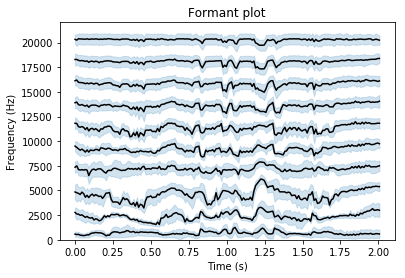

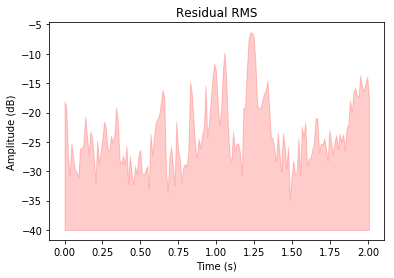

In [976]:
plot_formant(modulator, frame_len=1000, order=20, use_lsp=True)
